# Lag-Llama testing
In this notebook, fine-tune Lag-Llama. 

The model is pretty heavy and inference is slow. I recommend you run this notebook on a GPU-enabled environment, such as Colab.

This notebook relies on the demo notebook for fine-tuning open-sourced by the authors of Lag-Llama: [Notebook 2](https://colab.research.google.com/drive/1uvTmh-pe1zO5TeaaRVDdoEWJ5dFDI-pA?usp=sharing)

## 0. Installing Lag-Llama

In [2]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [3]:
cd lag-llama

/content/lag-llama


In [4]:
!pip3 install -r requirements.txt --quiet
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 69.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

## 1. Imports and definitions

In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from torch import manual_seed
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset
import pandas as pd

from utils.utils import set_seed

from lag_llama.gluon.estimator import LagLlamaEstimator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns

from sklearn.metrics import mean_absolute_error

set_seed(42)

<ipython-input-5-4f0ace28ce4e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [7]:
def create_gluonts_dataset(df, freq, target_column):
    """
    Creates a GluonTS ListDataset from a pandas DataFrame.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the time series data.
    freq (str): Frequency string of the time series (e.g., 'D' for daily, 'H' for hourly).
    target_column (str): Name of the column in df that contains the target values.
    
    Returns:
    ListDataset: A GluonTS ListDataset object containing the time series data.
    """
    series = {
        "start": df.index[0],  # start date of the time series
        "target": df[target_column].values,  # target values
    }

    dataset = ListDataset([series], freq=freq)
    return dataset

In [8]:
def get_lag_llama_predictions(dataset,
                                model_ckpt,
                                prediction_length = 24,
                                context_length=None,
                                num_samples=100,
                                device="cuda",
                                batch_size=64,
                                nonnegative_pred_samples=True,
                              ):

    """
    Generates predictions using the LagLlama model from a given dataset.
    
    Parameters:
    dataset (ListDataset): The dataset containing the time series data for prediction.
    model_ckpt (str): Path to the model checkpoint.
    prediction_length (int): Number of time steps to predict. Default is 24.
    context_length (int, optional): Number of time steps used for context. If None, it is set from the model checkpoint.
    num_samples (int): Number of prediction samples. Default is 100.
    device (str): Device to run the model on ('cuda' or 'cpu'). Default is 'cuda'.
    batch_size (int): Batch size for predictions. Default is 64.
    nonnegative_pred_samples (bool): Whether to ensure non-negative prediction samples. Default is True.
    
    Returns:
    tuple: A tuple containing:
        - forecasts (list): List of forecasted values.
        - tss (list): List of ground truth values.
    """
    
    manual_seed(42)
    _device = torch.device(device)
    _ckpt = torch.load(model_ckpt, map_location=_device)
    estimator_args = _ckpt["hyper_parameters"]["model_kwargs"]
    if context_length == None:
      context_length=estimator_args['context_length']

    estimator = LagLlamaEstimator(
        ckpt_path = model_ckpt,
        context_length=context_length,
        prediction_length=prediction_length,
        device = _device,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
              "type": "linear",
              "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
          },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module().to(device)
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset[0]['target']), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset[0]['target']), desc="Ground truth"))

    return forecasts, tss

In [9]:
def plot_preds(model_dir, title):
    """
    Plots predictions from the LagLlama model for the first 9 time series in the dataset.
    
    Parameters:
    model_dir (str): Path to the model checkpoint directory.
    title (str): Title of the plot.
    
    Returns:
    None
    """
  forecasts, tss = get_lag_llama_predictions(
      test,
      model_ckpt = model_dir,
      prediction_length=7,
      num_samples=100,
      # context_length=context_length,
      device=torch.device('cuda')
    )

  plt.figure(figsize=(20, 15))
  date_formater = mdates.DateFormatter('%b, %d')
  plt.rcParams.update({'font.size': 15})

  # Iterate through the first 9 series, and plot the predicted samples
  for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
      ax = plt.subplot(3, 3, idx+1)

      plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
      forecast.plot( color='g')
      plt.xticks(rotation=60)
      ax.xaxis.set_major_formatter(date_formater)
      ax.set_title(forecast.item_id)

  plt.gcf().tight_layout()
  plt.title(title)
  plt.legend()
  plt.show()

## 2. Read and split data

In [12]:
# Read data
# ==============================================================================
data_dir = 'Data/spain/four years'

df = pd.read_csv(data_dir + '/spain_clean_daily.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('D')

# Train-test split
# ==============================================================================
one_month = (-1)*30 # One month
two_months = (-1)*60 # Two months

end_val = two_months + two_months + one_month
end_train = end_val + two_months + two_months + one_month

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-19 00:00:00 --- 2023-08-24 00:00:00  (n=1162)
Validation dates : 2023-08-25 00:00:00 --- 2024-01-21 00:00:00  (n=150)
Test dates       : 2024-01-22 00:00:00 --- 2024-06-19 00:00:00  (n=150)


In [13]:
# Create the GluonTS dataset
train = create_gluonts_dataset(df_train, freq='D', target_column='wave_height')
test = create_gluonts_dataset(df_test, freq='D', target_column='wave_height')
val = create_gluonts_dataset(df_val, freq='D', target_column='wave_height')

print('Train dataset       :', train)
print('Validation dataset  :',val)
print('Test dataset        :',test)

Train dataset       : [{'start': Period('2020-06-19', 'D'), 'target': array([0.87, 0.9 , 0.7 , ..., 1.09, 1.08, 0.95], dtype=float32)}]
Validation dataset  : [{'start': Period('2023-08-25', 'D'), 'target': array([1.26     , 0.97     , 1.22     , 1.6      , 1.52     , 1.24     ,
       1.15     , 0.97     , 0.91     , 1.23     , 2.49     , 1.95     ,
       1.73     , 1.47     , 0.92     , 0.52     , 0.61     , 0.67     ,
       1.17     , 1.07     , 1.06     , 1.15     , 0.85     , 0.93     ,
       1.09     , 1.61     , 1.98     , 1.99     , 2.82     , 2.76     ,
       1.64     , 1.35     , 1.72     , 1.72     , 1.45     , 1.92     ,
       1.24     , 1.08     , 0.93     , 1.07     , 1.46     , 1.61     ,
       1.14     , 0.91     , 1.07     , 0.72     , 0.5      , 0.37     ,
       0.22     , 1.02     , 1.57     , 1.63     , 2.34     , 1.49     ,
       0.8      , 2.13     , 1.7      , 4.84     , 3.43     , 2.69     ,
       1.71     , 1.18     , 2.05     , 2.36     , 2.88     , 2.

## 3. Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [14]:
manual_seed(42)

context_lengths = [32, 64, 128]
learning_rates = [1e-3, 5e-4, 1e-4]
prediction_length = 7
device = torch.device('cuda')
num_samples = 200

results = []

for context_length in context_lengths:
    for lr in learning_rates:

        # Define the model
        ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=device)
        estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

        estimator = LagLlamaEstimator(
                ckpt_path="lag-llama/lag-llama.ckpt",
                prediction_length=prediction_length,
                context_length=context_length,
                device = device,

                # distr_output="neg_bin",
                # scaling="mean",
                nonnegative_pred_samples=True,
                aug_prob=0,
                lr=lr,

                # estimator args
                input_size=estimator_args["input_size"],
                n_layer=estimator_args["n_layer"],
                n_embd_per_head=estimator_args["n_embd_per_head"],
                n_head=estimator_args["n_head"],
                time_feat=estimator_args["time_feat"],

                rope_scaling={
                    "type": "linear",
                    "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
                },

                batch_size=64,
                num_parallel_samples=num_samples,
                trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
            )

        # Train the model
        predictor = estimator.train(training_data = train, validation_data = val, cache_data=True, shuffle_buffer_length=1000)

        # Evaluate the model
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=test,
            predictor=predictor,
            num_samples=num_samples
        )

        forecasts = list(forecast_it)
        tss = list(ts_it)
        evaluator = Evaluator()
        agg_metrics, _ = evaluator(iter(tss), iter(forecasts), num_series=len(test))

        # Store evaluation results
        results.append({
            'context_length': context_length,
            'lr': lr,
            'Coverage[0.8]': agg_metrics['Coverage[0.8]'],
            'Coverage[0.9]': agg_metrics['Coverage[0.9]'],
            'MAE_Coverage': agg_metrics['MAE_Coverage']
        })

# Print results

print(results)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augment

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.78706 (best 0.78706), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.78706 (best 0.78706), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.43412 (best 0.43412), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.43412 (best 0.43412), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -0.20120 (best -0.20120), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pyt

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.66933 (best 0.66933), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.66933 (best 0.66933), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.15147 (best 0.15147), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.15147 (best 0.15147), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -0.43596 (best -0.43596), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pyt

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.48211 (best 0.48211), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.48211 (best 0.48211), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -0.12707 (best -0.12707), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.12707 (best -0.12707), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -0.75658 (best -0.75658), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.88665 (best 0.88665), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.88665 (best 0.88665), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.48030 (best 0.48030), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.48030 (best 0.48030), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 0.15236 (best 0.15236), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.74605 (best 0.74605), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.74605 (best 0.74605), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.44443 (best 0.44443), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.44443 (best 0.44443), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 0.01891 (best 0.01891), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.53506 (best 0.53506), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.53506 (best 0.53506), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -0.01827 (best -0.01827), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.01827 (best -0.01827), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -0.57607 (best -0.57607), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.99470 (best 0.99470), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.99470 (best 0.99470), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.55568 (best 0.55568), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.55568 (best 0.55568), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 0.19183 (best 0.19183), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.76188 (best 0.76188), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.76188 (best 0.76188), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.49611 (best 0.49611), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.49611 (best 0.49611), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 0.18640 (best 0.18640), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.57786 (best 0.57786), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.57786 (best 0.57786), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.07195 (best 0.07195), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.07195 (best 0.07195), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -0.36746 (best -0.36746), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pyt

[{'context_length': 32, 'lr': 0.001, 'Coverage[0.8]': 1.0, 'Coverage[0.9]': 1.0, 'MAE_Coverage': 0.5}, {'context_length': 32, 'lr': 0.0005, 'Coverage[0.8]': 0.8571428571428571, 'Coverage[0.9]': 0.8571428571428571, 'MAE_Coverage': 0.36666666666666664}, {'context_length': 32, 'lr': 0.0001, 'Coverage[0.8]': 0.7142857142857143, 'Coverage[0.9]': 0.7142857142857143, 'MAE_Coverage': 0.2746031746031746}, {'context_length': 64, 'lr': 0.001, 'Coverage[0.8]': 0.8571428571428571, 'Coverage[0.9]': 0.8571428571428571, 'MAE_Coverage': 0.36666666666666664}, {'context_length': 64, 'lr': 0.0005, 'Coverage[0.8]': 0.7142857142857143, 'Coverage[0.9]': 0.7142857142857143, 'MAE_Coverage': 0.2746031746031746}, {'context_length': 64, 'lr': 0.0001, 'Coverage[0.8]': 0.7142857142857143, 'Coverage[0.9]': 0.7142857142857143, 'MAE_Coverage': 0.2746031746031746}, {'context_length': 128, 'lr': 0.001, 'Coverage[0.8]': 1.0, 'Coverage[0.9]': 1.0, 'MAE_Coverage': 0.5}, {'context_length': 128, 'lr': 0.0005, 'Coverage[0.8]'

In [15]:
# Print results
# =====================================================
results

[{'context_length': 32,
  'lr': 0.001,
  'Coverage[0.8]': 1.0,
  'Coverage[0.9]': 1.0,
  'MAE_Coverage': 0.5},
 {'context_length': 32,
  'lr': 0.0005,
  'Coverage[0.8]': 0.8571428571428571,
  'Coverage[0.9]': 0.8571428571428571,
  'MAE_Coverage': 0.36666666666666664},
 {'context_length': 32,
  'lr': 0.0001,
  'Coverage[0.8]': 0.7142857142857143,
  'Coverage[0.9]': 0.7142857142857143,
  'MAE_Coverage': 0.2746031746031746},
 {'context_length': 64,
  'lr': 0.001,
  'Coverage[0.8]': 0.8571428571428571,
  'Coverage[0.9]': 0.8571428571428571,
  'MAE_Coverage': 0.36666666666666664},
 {'context_length': 64,
  'lr': 0.0005,
  'Coverage[0.8]': 0.7142857142857143,
  'Coverage[0.9]': 0.7142857142857143,
  'MAE_Coverage': 0.2746031746031746},
 {'context_length': 64,
  'lr': 0.0001,
  'Coverage[0.8]': 0.7142857142857143,
  'Coverage[0.9]': 0.7142857142857143,
  'MAE_Coverage': 0.2746031746031746},
 {'context_length': 128,
  'lr': 0.001,
  'Coverage[0.8]': 1.0,
  'Coverage[0.9]': 1.0,
  'MAE_Coverage

## 4. Plotting

Forecasting batches:   0%|          | 0/150 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/150 [00:00<?, ?it/s]

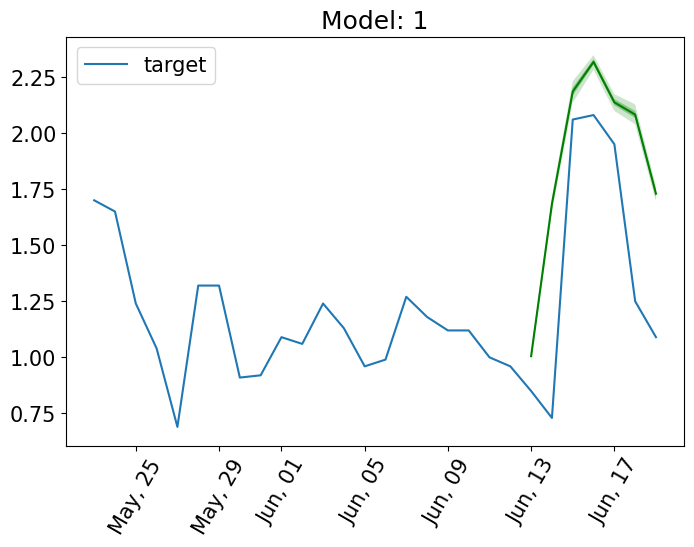

Forecasting batches:   0%|          | 0/150 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/150 [00:00<?, ?it/s]

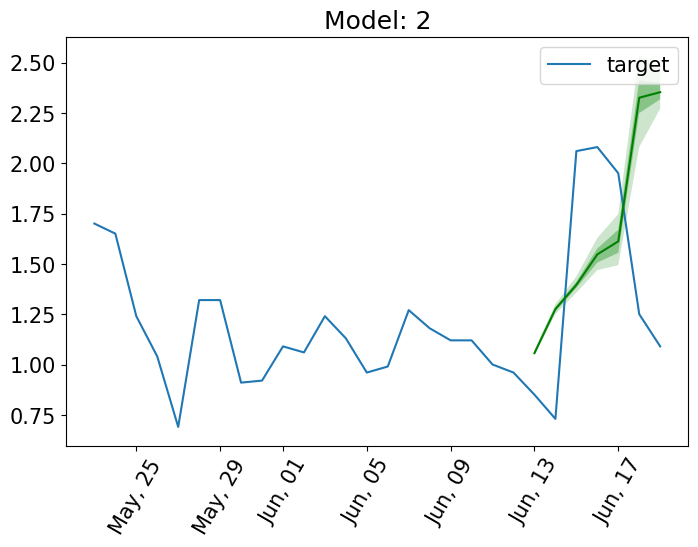

Forecasting batches:   0%|          | 0/150 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/150 [00:00<?, ?it/s]

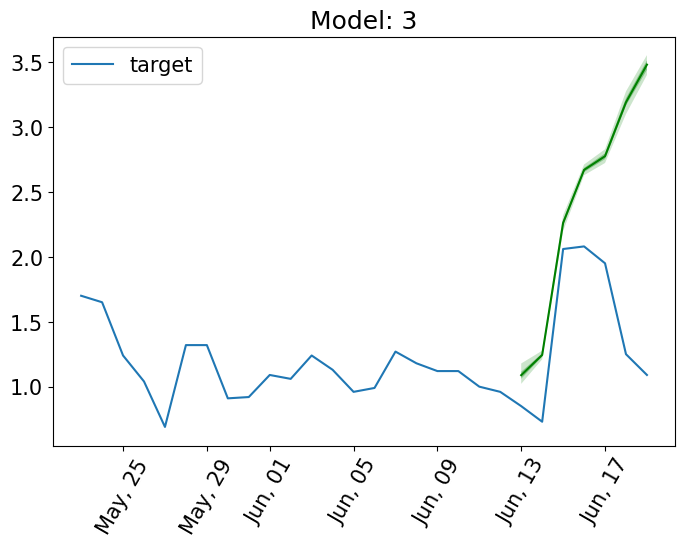

Forecasting batches:   0%|          | 0/150 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/150 [00:00<?, ?it/s]

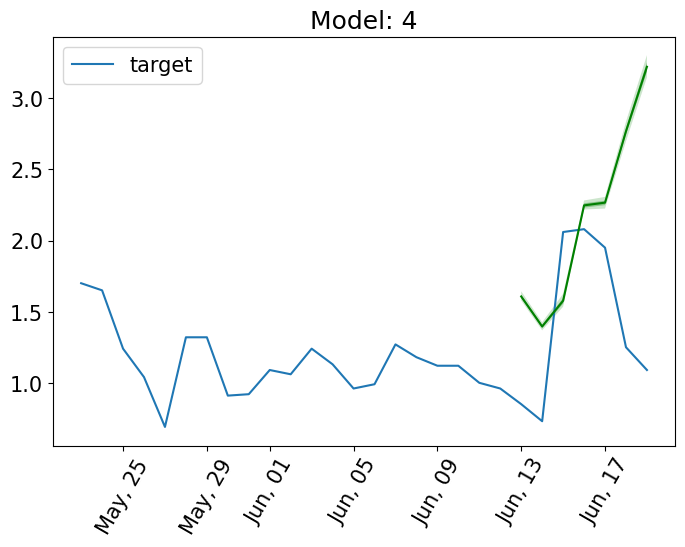

Forecasting batches:   0%|          | 0/150 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/150 [00:00<?, ?it/s]

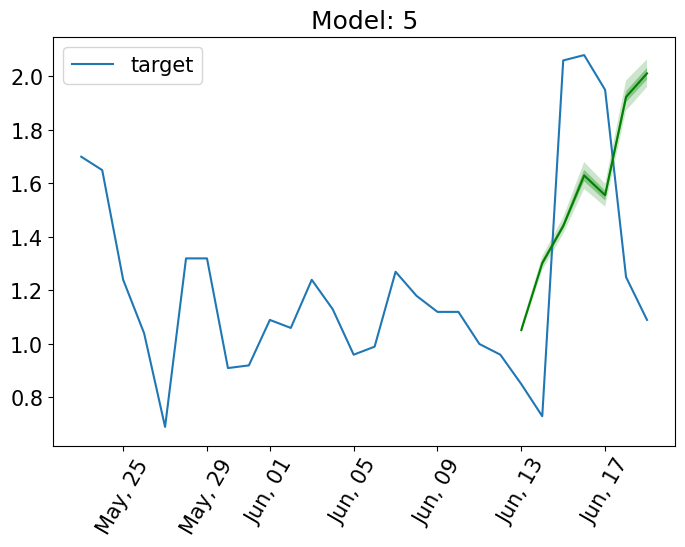

Forecasting batches:   0%|          | 0/150 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/150 [00:00<?, ?it/s]

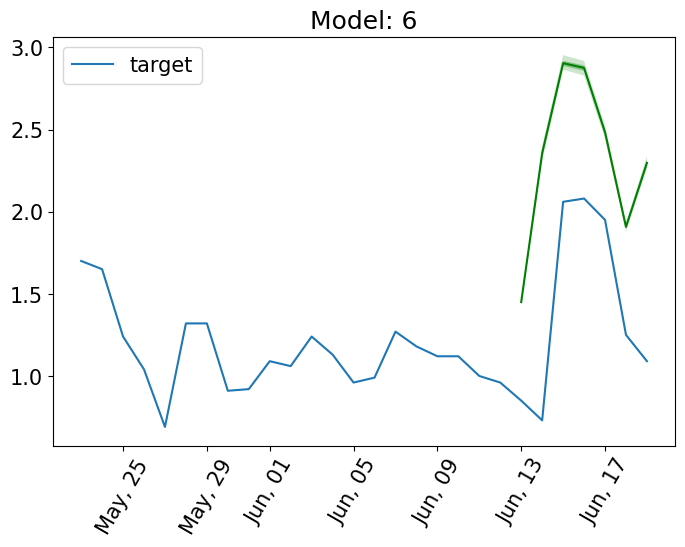

Forecasting batches:   0%|          | 0/150 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/150 [00:00<?, ?it/s]

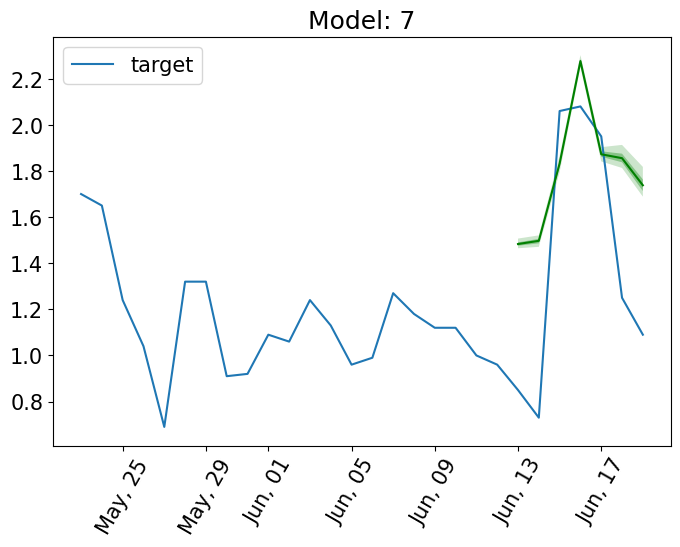

Forecasting batches:   0%|          | 0/150 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/150 [00:00<?, ?it/s]

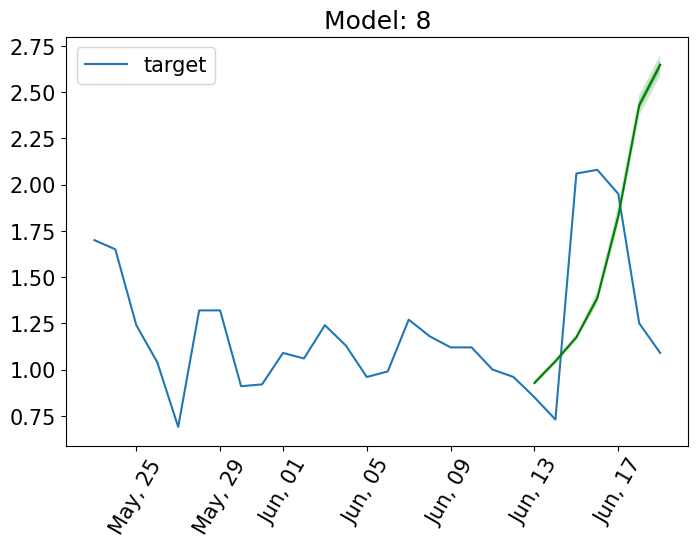

In [16]:
import os
files = range(1,9,1)
for file in files:
  directory_path = f'/content/lag-llama/lightning_logs/version_{file}/checkpoints'
  with os.scandir(directory_path) as entries:
    for entry in entries:
        # Check if it's a file
        if entry.is_file():
          model_dir = directory_path + '/' + entry.name
          plot_preds(model_dir, 'Model: '+ str(file))
